In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import math as mt

import fixedint as fx

In [2]:
class RNGenerator():
    def __init__(self, seed):
        if seed == 0:
            raise ValueError("Seed can't be 0!")

        self.state = fx.MutableUInt64(seed)

    def step(self):
        new_bit = (self.state ^ (self.state >> 1) ^ (self.state >> 5) ^ (self.state >> 6) ^ (self.state >> 31)) & 1
        self.state = (self.state >> 1) | (new_bit << (64 - 1))
        return new_bit

    def generate_number(self):
        number = 0
        for _ in range(64):
            number = (number << 1) | self.step()
        return number

    def simulate_uniform_rv(self):
        return self.generate_number() / 0xFFFFFFFFFFFFFFFF

    def generate_number_upper_limited(self, superior_limit):
        return (self.simulate_uniform_rv()) * superior_limit

generator = RNGenerator(0x0F0F0F0F0F0F0F0F0F)

In [3]:
# Create the RNG for the simulation
sim_generator = RNGenerator(0x123123123123123123)

In [4]:
import math

class PoissonProcess():
    def __init__(self, step_duration, pedestrian_rate, car_rate, random_seed):
        self.generator = RNGenerator(random_seed)
        self.step_duration = step_duration
        
        self.CONSTANT_CAR_SPEED = 5
        self.MAX_PEDESTRIAN_SPEED = 6
    
        self.pedestrian_rate = pedestrian_rate
        self.time_till_next_pedestrian = 0
        self.car_rate = car_rate
        self.time_till_next_car = 0
    
    # Method to simulate the time between arrivals
    # Uses F^-1, the inverse of the CDF of the exponential distribution
    def simulate_time_between_events(self, rate):
        u = self.generator.simulate_uniform_rv()
        return math.log(1-u)/(-rate) 
    
    
    # Definition of the Process functions (Spawning entities)

    # [pedestrian_speed] = blocks/second
    def generate_pedestrian(self):
        random_value = self.generator.simulate_uniform_rv()
        if random_value <= 0.273:
            pedestrian_speed = 2
        elif random_value <= 0.793:
            pedestrian_speed = 3
        elif random_value <= 0.93:
            pedestrian_speed = 4
        elif random_value <= 0.978:
            pedestrian_speed = 5
        else:
            pedestrian_speed = self.MAX_PEDESTRIAN_SPEED
        
        #random_value = self.generator.simulate_uniform_rv()
        #if random_value <= 0.5:
        #    pedestrian_direction = LEFT
        #else:
        #    pedestrian_position = RIGHT
        return Struct("if").pack(PEDESTRIAN, pedestrian_speed)
        

    def spawn_pedestrians(self):
        pedestrians_generated = []
        if self.time_till_next_pedestrian >= self.step_duration:
            self.time_till_next_pedestrian -= self.step_duration
        else:
            time_elapsed = self.time_till_next_pedestrian
            pedestrians_generated.append(self.generate_pedestrian())
            while time_elapsed < self.step_duration:
                next_spawn_time = self.simulate_time_between_events(self.pedestrian_rate)
                time_elapsed += next_spawn_time
                if time_elapsed < self.step_duration:
                    pedestrians_generated.append(self.generate_pedestrian())
            self.time_till_next_pedestrian = time_elapsed - self.step_duration
        return pedestrians_generated
        
        
    def generate_car(self):
        return Struct("if").pack(CAR, self.CONSTANT_CAR_SPEED)


    def spawn_cars(self):
        cars_generated = []
        if self.time_till_next_car >= self.step_duration:
            self.time_till_next_car -= self.step_duration
        else:
            time_elapsed = self.time_till_next_car
            cars_generated.append(self.generate_car())
            while time_elapsed < self.step_duration:
                next_spawn_time = self.simulate_time_between_events(self.car_rate)
                time_elapsed += next_spawn_time
                if time_elapsed < self.step_duration:
                    cars_generated.append(self.generate_car())
            self.time_till_next_car = time_elapsed - self.step_duration
        return cars_generated
    
    
    def get_max_pedestrian_speed(self):
        return self.MAX_PEDESTRIAN_SPEED

In [5]:
class ResultsTracker():
    def __init__(self):
        self.conflicts_car_pedestrian = 0
        self.conflicts_pedestrian_pedestrian = 0
        self.conflicts_car_car = 0
        
        self.pedestrians_spawned = 0
        self.pedestrians_that_crossed = 0
        self.pedestrians_that_crossed_safely = 0
        self.pedestrians_that_crossed_in_green = 0
        self.cars_spawned = 0
        self.cars_that_crossed = 0
        self.lane_swaps = 0
        self.failed_lane_swaps = 0
        self.bottle_necks = 0
        self.failed_pedestrian_spawns = 0
        self.failed_car_spawns = 0
        
    def track_spawn(self, entity):
        if entity == PEDESTRIAN:
            self.pedestrians_spawned += 1
        elif entity == CAR:
            self.cars_spawned += 1

    def track_conflict(self, entity1, entity2):
        if entity1 == PEDESTRIAN and entity2 == PEDESTRIAN:
            self.conflicts_pedestrian_pedestrian += 1
        elif entity1 == PEDESTRIAN and entity2 == CAR or entity1 == CAR and entity2 == PEDESTRIAN:
            self.conflicts_car_pedestrian += 1
        elif entity1 == CAR and entity2 == CAR:
            self.conflicts_car_car += 1

    def track_crossing(self, entity, is_light_green):
        if entity == PEDESTRIAN:
            self.pedestrians_that_crossed += 1
            if is_light_green:
                self.pedestrians_that_crossed_in_green += 1
            else:
                self.pedestrians_that_crossed_safely += 1
        elif entity == CAR:
            self.cars_that_crossed += 1

    def track_lane_swap(self):
        self.lane_swaps += 1

    def track_fail_in_lane_swap(self):
        self.failed_lane_swaps += 1

    def track_bottle_neck(self):
        self.bottle_necks += 1

    def track_fail_in_spawn(self, entity):
        if entity == PEDESTRIAN:
            self.failed_pedestrian_spawns += 1
        elif entity == CAR:
            self.failed_car_spawns += 1

    def print_results(self):
        print("Results of the simulation:")
        print(f"Pedestrians that crossed: {self.pedestrians_that_crossed}")
        print(f"Pedestrians that crossed safely: {self.pedestrians_that_crossed_safely}")
        print(f"Pedestrians that crossed in green: {self.pedestrians_that_crossed_in_green}")
        print(f"Cars that crossed: {self.cars_that_crossed}")
        print(f"Conflicts between pedestrians: {self.conflicts_pedestrian_pedestrian}")
        print(f"Conflicts between pedestrians and cars: {self.conflicts_car_pedestrian}")
        print(f"Conflicts between cars: {self.conflicts_car_car}")
        print(f"Lane swaps: {self.lane_swaps}")
        print(f"Failed lane swaps: {self.failed_lane_swaps}")
        print(f"Bottle necks: {self.bottle_necks}")
        print(f"Pedestrians spawned: {self.pedestrians_spawned}")
        print(f"Failed pedestrian spawns: {self.failed_pedestrian_spawns}")
        print(f"Cars spawned: {self.cars_spawned}")
        print(f"Failed car spawns: {self.failed_car_spawns}")

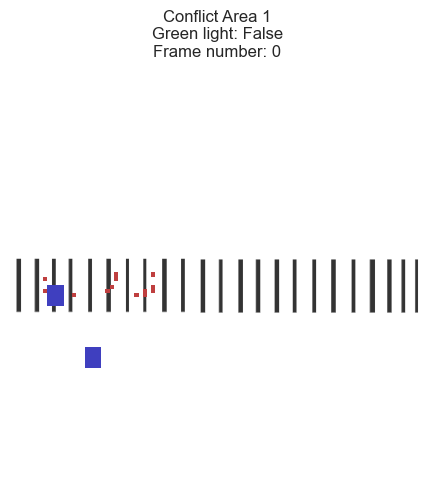

In [27]:
from struct import Struct
from queue import SimpleQueue
from threading import Thread, Lock
from PIL import Image

# Definition of matrix and general constants
EMPTY = -1
FLOOR = 0
PEDESTRIAN = 1
CAR = 2
SIDEWALK = 3

class ConflictArea1():
    def __init__(self, tracker, step_duration, traffic_light_duration, dimension, amount_of_crossing_rows, sidewalk_length, entity_process, random_seed):
        self.conflict_tracker = tracker
        self.generator = RNGenerator(random_seed)
        self.dimension = dimension
        self.entity_process = entity_process
        self.time_elapsed = 0
        self.step_duration = step_duration

        self.traffic_light_green = False # The simulation starts giving pedestrians pass
        self.traffic_light_duration = traffic_light_duration

        self.TRIES_IN_LOCATING_ENTITIES = 20
        self.CAR_LENGTH = 4
        self.CAR_HEIGHT = 5

        self.current_space_matrix = []
        for i in range(dimension):
            self.current_space_matrix.append([])
            for j in range(dimension):
                self.current_space_matrix[i].append(Struct("if").pack(FLOOR, 0))

        self.step_lock = Lock() #Lock for stepping with concurrency
        self.amount_of_crossing_rows = amount_of_crossing_rows
        self.sidewalk_lenght = sidewalk_length

        self.pedestrian_movement_queues = {}
        for i in range(amount_of_crossing_rows):
            self.pedestrian_movement_queues[i+int(self.dimension/2)] = SimpleQueue()

        self.cars_in_space = []

    # Matrix manipulation functions

    def distance_to_closest_neighbor(self, x_coordinate, y_coordinate):
        min_distance = EMPTY
        for j in range(self.dimension):
            if Struct("if").unpack(self.current_space_matrix[x_coordinate][j])[0] == PEDESTRIAN and j != y_coordinate:
                distance = abs(y_coordinate-j)
                if min_distance == EMPTY:
                    min_distance = distance
                else:
                    min_distance = min(min_distance, distance)
        return min_distance


    def generate_random_pedestrian_position(self, pedestrian_data):
        tries_in_locating_pedestrian = 0
        found_position = False
        x_coordinate, y_coordinate = 0, 0
        while (not found_position) and (tries_in_locating_pedestrian < self.TRIES_IN_LOCATING_ENTITIES):
            x_coordinate = int(self.dimension/2) + int(self.generator.generate_number_upper_limited(self.amount_of_crossing_rows))
            y_coordinate = int(self.generator.generate_number_upper_limited(self.sidewalk_lenght))
            tries_in_locating_pedestrian += 1
            if Struct("if").unpack(self.current_space_matrix[x_coordinate][y_coordinate])[0] == FLOOR:
                found_position = True
            else:
                self.conflict_tracker.track_fail_in_spawn(PEDESTRIAN)

        if not found_position:
            return
        self.conflict_tracker.track_spawn(PEDESTRIAN)
        self.current_space_matrix[x_coordinate][y_coordinate] = pedestrian_data


    def generate_random_car_position(self, car_data):
        tries_in_locating_car = 0
        found_position = False
        x_top_left, y_top_left = 0, 0
        while (not found_position) and (tries_in_locating_car < self.TRIES_IN_LOCATING_ENTITIES):
            x_top_left = int(self.generator.generate_number_upper_limited(2)) + int(self.dimension/4)
            y_top_left = int(self.generator.generate_number_upper_limited(int(self.dimension/4) - (self.sidewalk_lenght)*2)) + self.sidewalk_lenght
            tries_in_locating_car += 1

            i,j, possible_position = 0, 0, True
            while i < self.CAR_HEIGHT and possible_position:
                while j < self.CAR_LENGTH and possible_position:
                    if Struct("if").unpack(self.current_space_matrix[x_top_left+i][y_top_left+j])[0] != FLOOR:
                        possible_position = False
                        self.conflict_tracker.track_fail_in_spawn(CAR)
                        continue
                    else:
                        possible_position = True
                    j += 1
                i += 1
            found_position = possible_position

        if not found_position:
            return

        for i in range(self.CAR_HEIGHT):
            for j in range(self.CAR_LENGTH):
                self.current_space_matrix[x_top_left+i][y_top_left+j] = car_data
        self.conflict_tracker.track_spawn(CAR)
        self.cars_in_space.append((x_top_left, y_top_left, car_data))


    def generate_simulation_entities(self):
        pedestrians_spawned = self.entity_process.spawn_pedestrians()
        for pedestrian_data in pedestrians_spawned:
            self.generate_random_pedestrian_position(pedestrian_data)
        
        if not self.traffic_light_green:
            cars_spawned = self.entity_process.spawn_cars()
            for car_data in cars_spawned:
                self.generate_random_car_position(car_data)


    def update_traffic_light(self):
        if self.time_elapsed == self.traffic_light_duration:
            self.traffic_light_green = not self.traffic_light_green
            self.time_elapsed = 0
        else:
            self.time_elapsed += self.step_duration


    def simulation_step(self):
        self.generate_simulation_entities()
        self.update_traffic_light()
        self.entities_position_step()


    def entities_position_step(self):
        crossing_row_threads = []
        for i in range(self.amount_of_crossing_rows):
            t = Thread(target=self.pedestrian_row_step, args=[i+int(self.dimension/2)])
            t.start()
            crossing_row_threads.append(t)

        car_t = Thread(target=self.car_step, args=[])
        car_t.start()

        for t in crossing_row_threads:
            t.join()

        car_t.join()


    def pedestrian_row_step(self, row_number):
        for j in range(self.dimension):
            if Struct("if").unpack(self.current_space_matrix[row_number][j])[0] == PEDESTRIAN:
                self.handle_pedestrian_movement(row_number, j)
        self.resolve_pending_movements_in_row(row_number)


    def pedestrian_in_sidewalk(self, y_coordinate):
        return (not (y_coordinate < self.sidewalk_lenght) or (y_coordinate >= (self.dimension - self.sidewalk_lenght)))


    def handle_pedestrian_movement(self, x_coordinate, y_coordinate):
        distance_to_closest_neighbor = self.distance_to_closest_neighbor(x_coordinate, y_coordinate)
        if self.traffic_light_green:
            if self.pedestrian_in_sidewalk(y_coordinate):
                current_speed = self.entity_process.get_max_pedestrian_speed()
            else:
                current_speed = 0
                #return
        else:
            current_speed = Struct("if").unpack(self.current_space_matrix[x_coordinate][y_coordinate])[1]

        if (distance_to_closest_neighbor == EMPTY) or (self.traffic_light_green):
            pedestrian_speed = current_speed
        else:
            pedestrian_speed = min(current_speed, distance_to_closest_neighbor)

        blocks_to_move = mt.ceil(pedestrian_speed*self.step_duration)

        if (y_coordinate + blocks_to_move) >= self.dimension:
            self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
            self.conflict_tracker.track_crossing(PEDESTRIAN, self.traffic_light_green)
        else:
            self.pedestrian_movement_queues[x_coordinate].put((x_coordinate, y_coordinate, Struct("if").pack(PEDESTRIAN, pedestrian_speed), blocks_to_move))


    def car_step(self):
        cars_to_remove = []
        for i in range(len(self.cars_in_space)):
            upper_left_x_coordinate, upper_left_y_coordinate, car_data = self.cars_in_space[i]
            index = self.move_car(upper_left_x_coordinate, upper_left_y_coordinate, car_data, i)
            if index == EMPTY:
                continue
            cars_to_remove.append(self.cars_in_space[index])

        for car in cars_to_remove:
            self.cars_in_space.remove(car)
            self.conflict_tracker.track_crossing(CAR, self.traffic_light_green)


    def move_car(self, upper_left_x_coordinate, upper_left_y_coordinate, car_data, index):
        self.step_lock.acquire()
        blocks_to_move = mt.ceil((Struct("if").unpack(car_data)[1])*self.step_duration)
        while blocks_to_move > 0:
            for j in range(self.CAR_LENGTH):
                if (upper_left_x_coordinate+self.CAR_HEIGHT) >= self.dimension:
                    self.remove_car(upper_left_x_coordinate, upper_left_y_coordinate)
                    self.step_lock.release()
                    return index

                entity_in_front = Struct('if').unpack(self.current_space_matrix[upper_left_x_coordinate+self.CAR_HEIGHT][upper_left_y_coordinate+j])[0]

                if entity_in_front == CAR:
                    self.conflict_tracker.track_conflict(CAR, CAR)
                    self.step_lock.release()
                    return EMPTY

                if entity_in_front == PEDESTRIAN:
                    self.conflict_tracker.track_conflict(CAR, PEDESTRIAN)
                    car_lets_pedestrian_pass = (generator.simulate_uniform_rv() >= 0.5)
                    if car_lets_pedestrian_pass: # if u < 0.5 pedestrian has priority, else car keeps moving
                        self.step_lock.release()
                        return EMPTY

                    pedestrian_x, pedestrian_y = upper_left_x_coordinate+self.CAR_HEIGHT, upper_left_y_coordinate+j
                    while Struct("if").unpack(self.current_space_matrix[pedestrian_x - 1][pedestrian_y])[0] == CAR:
                        if Struct("if").unpack(self.current_space_matrix[pedestrian_x][pedestrian_y-1])[0] == PEDESTRIAN:
                            self.conflict_tracker.track_bottle_neck()
                            self.step_lock.release()
                            return EMPTY
                        pedestrian_data = self.current_space_matrix[pedestrian_x][pedestrian_y]
                        self.current_space_matrix[pedestrian_x][pedestrian_y] = Struct("if").pack(FLOOR, 0)
                        pedestrian_y -= 1
                        self.current_space_matrix[pedestrian_x][pedestrian_y] = pedestrian_data

            for k in range(self.CAR_LENGTH):
                self.current_space_matrix[upper_left_x_coordinate][upper_left_y_coordinate+k] = Struct("if").pack(FLOOR, 0)
                self.current_space_matrix[upper_left_x_coordinate+self.CAR_HEIGHT][upper_left_y_coordinate+k] = car_data
            upper_left_x_coordinate += 1
            blocks_to_move -= 1
            self.cars_in_space[index] = (upper_left_x_coordinate, upper_left_y_coordinate, car_data)

        self.step_lock.release()
        self.cars_in_space[index] = (upper_left_x_coordinate, upper_left_y_coordinate, car_data)
        return EMPTY


    def remove_car(self, upper_left_x_coordinate, upper_left_y_coordinate):
        for i in range(self.CAR_HEIGHT):
            for j in range(self.CAR_LENGTH):
                self.current_space_matrix[upper_left_x_coordinate+i][upper_left_y_coordinate+j] = Struct("if").pack(FLOOR, 0)


    def resolve_pending_movements_in_row(self, row_number):
        while not self.pedestrian_movement_queues[row_number].empty():
            x_coordinate, y_coordinate, pedestrian_data, blocks_to_move = self.pedestrian_movement_queues[row_number].get()
            self.move_pedestrian(x_coordinate, y_coordinate, blocks_to_move, pedestrian_data)


    def move_pedestrian(self, old_x_coordinate, old_y_coordinate, blocks_to_move, pedestrian_data):
        self.step_lock.acquire()
        can_continue_moving = True
        current_x_coordinate, current_y_coordinate = old_x_coordinate, old_y_coordinate
        while blocks_to_move > 0 and can_continue_moving and current_y_coordinate < self.dimension-1:
            if Struct('if').unpack(self.current_space_matrix[current_x_coordinate][current_y_coordinate+1])[0] == FLOOR:
                self.current_space_matrix[current_x_coordinate][current_y_coordinate+1] = pedestrian_data
                self.current_space_matrix[current_x_coordinate][current_y_coordinate] = Struct("if").pack(FLOOR, 0)
                current_y_coordinate += 1
            elif Struct('if').unpack(self.current_space_matrix[current_x_coordinate][current_y_coordinate+1])[0] == PEDESTRIAN:
                self.conflict_tracker.track_conflict(PEDESTRIAN, PEDESTRIAN)
                can_continue_moving, current_x_coordinate = self.handle_lane_swap(current_x_coordinate, current_y_coordinate, pedestrian_data)
            blocks_to_move -= 1
        self.step_lock.release()


    def handle_lane_swap(self, x_coordinate, y_coordinate, pedestrian_data):
        #Conditions for lane swap

        # Behind a pedestrian 
        # && No pedestrian above or under 
        # && distance to nearest neighbor(x,y±1) > speed of pedestrian 
        # && speed of pedestrian behind up/dowm cell < speed of pedestrian 
        # swap up or down with equal probability

        # Behind a pedestrian 
        # && No pedestrian above
        # && Pedestrian under
        # && distance to nearest neighbor(x,y+1) > speed of pedestrian 
        # && speed of pedestrian behind up cell < speed of pedestrian
        # swap up

        ## Behind a pedestrian 
        # && Pedestrian above 
        # && No Pedestrian under
        # && distance to nearest neighbor(x,y-1) > speed of pedestrian 
        # && speed of pedestrian behind down cell < speed of pedestrian
        # swap under

        entity_under_position = Struct("if").unpack(self.current_space_matrix[x_coordinate+1][y_coordinate])[0]
        entity_above_position = Struct("if").unpack(self.current_space_matrix[x_coordinate-1][y_coordinate])[0]
        speed_of_pedestrian = Struct("if").unpack(pedestrian_data)[1]

        speed_of_nearest_upper_neighbor = self.speed_of_neighbor_behind(x_coordinate-1, y_coordinate)
        speed_of_nearest_lower_neighbor = self.speed_of_neighbor_behind(x_coordinate+1, y_coordinate)

        if entity_under_position == PEDESTRIAN and (entity_above_position == PEDESTRIAN):
            self.conflict_tracker.track_fail_in_lane_swap()
            return False, x_coordinate
        elif entity_under_position == PEDESTRIAN and (entity_above_position == FLOOR) and (x_coordinate-1 >= int(self.dimension/2)) : #Swap up
            distance_to_near_upper_neighbor = self.distance_to_closest_neighbor(x_coordinate - 1, y_coordinate)
            if distance_to_near_upper_neighbor != EMPTY:
                if distance_to_near_upper_neighbor > speed_of_pedestrian > speed_of_nearest_upper_neighbor:
                    self.current_space_matrix[x_coordinate-1][y_coordinate] = pedestrian_data
                    self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
                    x_coordinate -= 1
                else:
                    self.conflict_tracker.track_fail_in_lane_swap()
                    return False, x_coordinate
            else:
                if speed_of_pedestrian > speed_of_nearest_upper_neighbor:
                    self.current_space_matrix[x_coordinate-1][y_coordinate] = pedestrian_data
                    self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
                    x_coordinate -= 1
                else:
                    self.conflict_tracker.track_fail_in_lane_swap()
                    return False, x_coordinate
        elif entity_under_position == FLOOR and (entity_above_position == PEDESTRIAN) and (x_coordinate+1 < (int(self.dimension/2) + self.amount_of_crossing_rows)): #Swap down
            distance_to_near_lower_neighbor = self.distance_to_closest_neighbor(x_coordinate + 1, y_coordinate)
            if distance_to_near_lower_neighbor != EMPTY:
                if distance_to_near_lower_neighbor > speed_of_pedestrian > speed_of_nearest_lower_neighbor:
                    self.current_space_matrix[x_coordinate+1][y_coordinate] = pedestrian_data
                    self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
                    x_coordinate += 1
                else:
                    self.conflict_tracker.track_fail_in_lane_swap()
                    return False, x_coordinate
            else:
                if speed_of_pedestrian > speed_of_nearest_lower_neighbor:
                    self.current_space_matrix[x_coordinate+1][y_coordinate] = pedestrian_data
                    self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
                    x_coordinate += 1
                else:
                    self.conflict_tracker.track_fail_in_lane_swap()
                    return False, x_coordinate
        else:
            if (x_coordinate-1 >= int(self.dimension/2)) and (generator.simulate_uniform_rv() >= 0.5): #Swap up
                distance_to_near_upper_neighbor = self.distance_to_closest_neighbor(x_coordinate - 1, y_coordinate)
                if distance_to_near_upper_neighbor != EMPTY:
                    if distance_to_near_upper_neighbor > speed_of_pedestrian > speed_of_nearest_upper_neighbor:
                        self.current_space_matrix[x_coordinate-1][y_coordinate] = pedestrian_data
                        self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
                        x_coordinate -= 1
                    else:
                        self.conflict_tracker.track_fail_in_lane_swap()
                        return False, x_coordinate
                else:
                    if speed_of_pedestrian > speed_of_nearest_upper_neighbor:
                        self.current_space_matrix[x_coordinate-1][y_coordinate] = pedestrian_data
                        self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
                        x_coordinate -= 1
                    else:
                        self.conflict_tracker.track_fail_in_lane_swap()
                        return False, x_coordinate
            elif x_coordinate+1 < (int(self.dimension / 2) + self.amount_of_crossing_rows): #Swap down
                distance_to_near_lower_neighbor = self.distance_to_closest_neighbor(x_coordinate + 1, y_coordinate)
                if distance_to_near_lower_neighbor != EMPTY:
                    if distance_to_near_lower_neighbor > speed_of_pedestrian > speed_of_nearest_lower_neighbor:
                        self.current_space_matrix[x_coordinate+1][y_coordinate] = pedestrian_data
                        self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
                        x_coordinate += 1
                    else:
                        self.conflict_tracker.track_fail_in_lane_swap()
                        return False, x_coordinate
                else:
                    if speed_of_pedestrian > speed_of_nearest_lower_neighbor:
                        self.current_space_matrix[x_coordinate+1][y_coordinate] = pedestrian_data
                        self.current_space_matrix[x_coordinate][y_coordinate] = Struct("if").pack(FLOOR, 0)
                        x_coordinate += 1
                    else:
                        self.conflict_tracker.track_fail_in_lane_swap()
                        return False, x_coordinate
            else:
                self.conflict_tracker.track_fail_in_lane_swap()
                return False, x_coordinate
        self.conflict_tracker.track_lane_swap()
        return True, x_coordinate


    def speed_of_neighbor_behind(self, x_coordinate, y_coordinate):
        while self.current_space_matrix[x_coordinate][y_coordinate] == Struct("if").pack(FLOOR, 0) and y_coordinate > 0:
            y_coordinate -= 1
        return Struct("if").unpack(self.current_space_matrix[x_coordinate][y_coordinate])[1] #Floor speed defaults to zero


    def get_printable_matrix(self):
        animation_matrix = np.zeros((self.dimension, self.dimension))
        for i in range(self.dimension):
            for j in range(self.dimension):
                animation_matrix[i][j] = Struct("if").unpack(self.current_space_matrix[i][j])[0]
        return animation_matrix


# Definition of simulation parameters

PEDESTRIAN_RATE = 0.3 # lambda parameter of the pedestrian P.Process
CAR_RATE = 0.12 # lambda parameter of the car P.Process

# Defines how many steps fit in a second of simulation
TIME_SPLIT = 4
TRAFFIC_LIGHT_DURATION = 20

# Defines the simulation space
SPACE_DIMENSION = 100
AMOUNT_OF_CROSSING_ROWS = 6
SIDEWALK_LENGTH = 6

results_tracker = ResultsTracker()

# Initialization of simulation entities
process = PoissonProcess(1/TIME_SPLIT, PEDESTRIAN_RATE, CAR_RATE, sim_generator.generate_number())
street_space = ConflictArea1(results_tracker, 1/TIME_SPLIT, TRAFFIC_LIGHT_DURATION, SPACE_DIMENSION, AMOUNT_OF_CROSSING_ROWS, SIDEWALK_LENGTH, process, sim_generator.generate_number())

plt.rcParams["figure.figsize"] = [14.00, 6.50]
plt.rcParams["figure.autolayout"] = True
cmap = ListedColormap([[0.75, 0.25, 0.25], [0, 0, 0], [0.25, 0.25, 0.75]])
cmap.set_bad(alpha=0)  # Make masked values transparent

fig, ax = plt.subplots()

image = Image.open('image.png')

def update(frame):
    ax.cla()
    street_space.simulation_step()
    crosswalk_matrix = street_space.get_printable_matrix()
    masked_matrix = np.ma.masked_equal(crosswalk_matrix, 0) # Mask values at 0
    ax.imshow(image, extent=[0, SPACE_DIMENSION, int(SPACE_DIMENSION/4), int((3*SPACE_DIMENSION)/4)], aspect='auto', filternorm=True, filterrad=4.0, alpha=0.8)
    ax.imshow(masked_matrix, cmap=cmap)
    ax.set_title(f'Conflict Area 1'
                 f'\nGreen light: {street_space.traffic_light_green}'
                 f'\nFrame number: {frame}')
    ax.set_axis_off()

anim = FuncAnimation(fig, update, frames=350, interval=25)
fig.set_size_inches(6.5, 5, forward=True)

# Save the animation as a .gif file
anim.save('Conflict-Area-1.gif', writer='pillow', fps=12)

In [28]:
results_tracker.print_results()

Results of the simulation:
Pedestrians that crossed: 17
Pedestrians that crossed safely: 0
Pedestrians that crossed in green: 17
Cars that crossed: 3
Conflicts between pedestrians: 3
Conflicts between pedestrians and cars: 6
Conflicts between cars: 0
Lane swaps: 2
Failed lane swaps: 1
Bottle necks: 0
Pedestrians spawned: 30
Failed pedestrian spawns: 1
Cars spawned: 5
Failed car spawns: 0


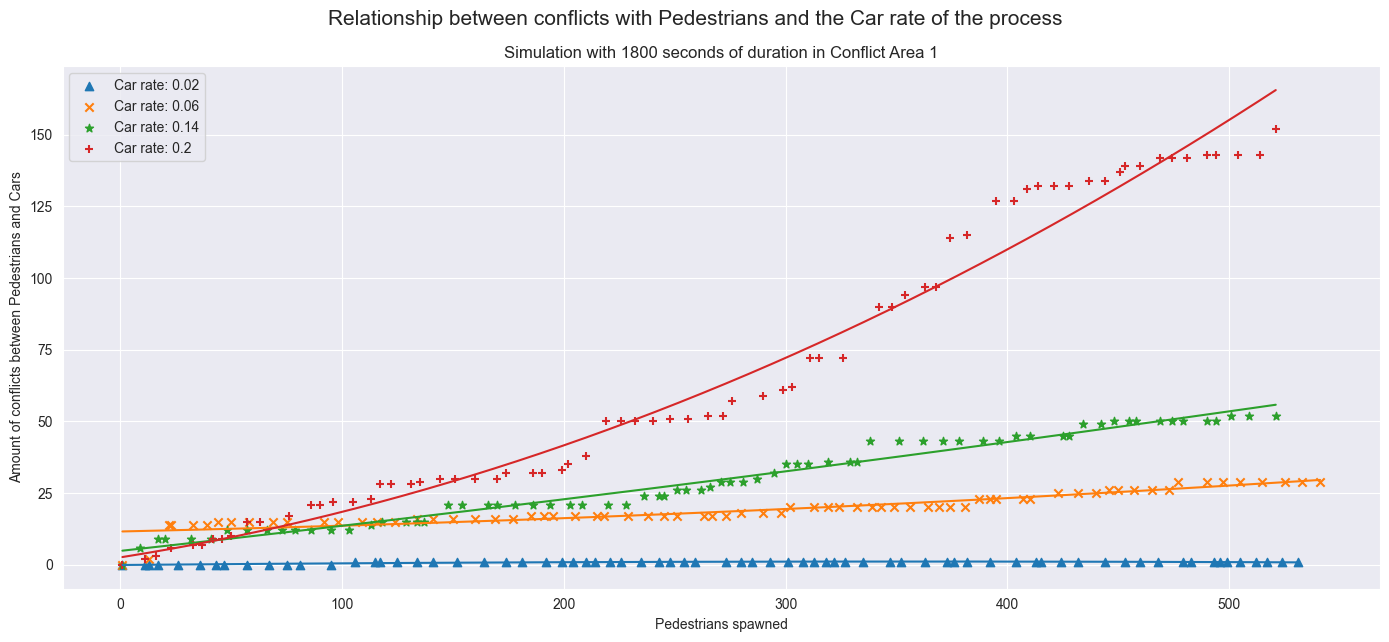

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

# Definition of simulation parameters

PEDESTRIAN_RATE = 0.3 # lambda parameter of the pedestrian P.Process

time_window = 1800 # Total duration of the simulation (in seconds)

# Defines how many steps fit in a second of simulation
TIME_SPLIT = 4
TRAFFIC_LIGHT_DURATION = 20

# Defines the simulation space
SPACE_DIMENSION = 100
AMOUNT_OF_CROSSING_ROWS = 5
SIDEWALK_LENGTH = 5

car_rates = [0.02, 0.06, 0.14, 0.20]
markers = ['^', 'x', '*', '+']

fig = plt.figure()
ax1 = fig.add_subplot(111)

data = []
plot_count = 0

for car_rate in car_rates:
    results_tracker = ResultsTracker()
    process = PoissonProcess(1/TIME_SPLIT, PEDESTRIAN_RATE, car_rate, sim_generator.generate_number())
    simulation = ConflictArea1(results_tracker, 1/TIME_SPLIT, TRAFFIC_LIGHT_DURATION, SPACE_DIMENSION, AMOUNT_OF_CROSSING_ROWS, SIDEWALK_LENGTH, process, sim_generator.generate_number())
    data.append([])
    for _ in range(int(time_window*TIME_SPLIT)):
        simulation.simulation_step()
        if _ % 100 == 0:
            data[plot_count].append((car_rate, results_tracker.pedestrians_spawned, results_tracker.conflicts_car_pedestrian))
    plot_count += 1

for i in range(plot_count):
    ax1.scatter([x[1] for x in data[i]], [x[2] for x in data[i]], marker=markers[i], label=f'Car rate: {car_rates[i]}')
    # quadratic regression
    x = [x[1] for x in data[i]]
    y = [x[2] for x in data[i]]

    model = np.poly1d(np.polyfit(x, y, 2))
    polyline = np.linspace(min(x), max(x), 200)
    plt.plot(polyline, model(polyline))

plt.xlabel('Pedestrians spawned')
plt.ylabel('Amount of conflicts between Pedestrians and Cars')

plt.suptitle("Relationship between conflicts with Pedestrians and the Car rate of the process", fontsize=15)
plt.title("Simulation with 1800 seconds of duration in Conflict Area 1", fontsize=12)

plt.legend()

plt.show()

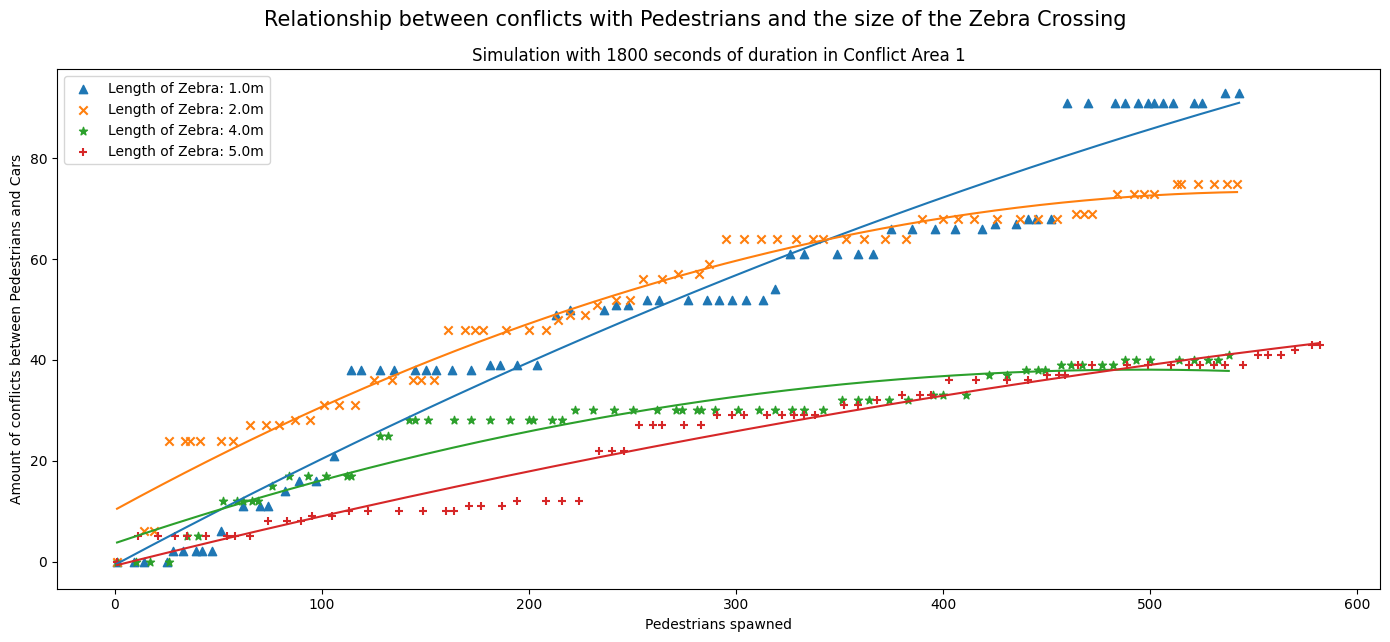

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

# Definition of simulation parameters

PEDESTRIAN_RATE = 0.3 # lambda parameter of the pedestrian P.Process

time_window = 1800 # Total duration of the simulation (in seconds)

# Defines how many steps fit in a second of simulation
TIME_SPLIT = 4
TRAFFIC_LIGHT_DURATION = 20
CAR_RATE = 0.08

# Defines the simulation space
SPACE_DIMENSION = 100
SIDEWALK_LENGTH = 5

markers = ['^', 'x', '*', '+']
crossing_road_lengths = [2, 4, 8, 10]

fig = plt.figure()
ax1 = fig.add_subplot(111)

data = []
plot_count = 0

for crossing_rows in crossing_road_lengths:
    results_tracker = ResultsTracker()
    process = PoissonProcess(1/TIME_SPLIT, PEDESTRIAN_RATE, CAR_RATE, sim_generator.generate_number())
    simulation = ConflictArea1(results_tracker, 1/TIME_SPLIT, TRAFFIC_LIGHT_DURATION, SPACE_DIMENSION, crossing_rows, SIDEWALK_LENGTH, process, sim_generator.generate_number())
    data.append([])
    for _ in range(int(time_window*TIME_SPLIT)):
        simulation.simulation_step()
        if _ % 100 == 0:
            data[plot_count].append((crossing_rows, results_tracker.pedestrians_spawned, results_tracker.conflicts_car_pedestrian))
    plot_count += 1

for i in range(plot_count):
    ax1.scatter([x[1] for x in data[i]], [x[2] for x in data[i]], marker=markers[i], label=f'Length of Zebra: {crossing_road_lengths[i]/2}m')
    # quadratic regression
    x = [x[1] for x in data[i]]
    y = [x[2] for x in data[i]]

    model = np.poly1d(np.polyfit(x, y, 2))
    polyline = np.linspace(min(x), max(x), 200)
    plt.plot(polyline, model(polyline))

plt.xlabel('Pedestrians spawned')
plt.ylabel('Amount of conflicts between Pedestrians and Cars')

plt.suptitle("Relationship between conflicts with Pedestrians and the size of the Zebra Crossing", fontsize=15)
plt.title("Simulation with 1800 seconds of duration in Conflict Area 1", fontsize=12)

plt.legend()

plt.show()

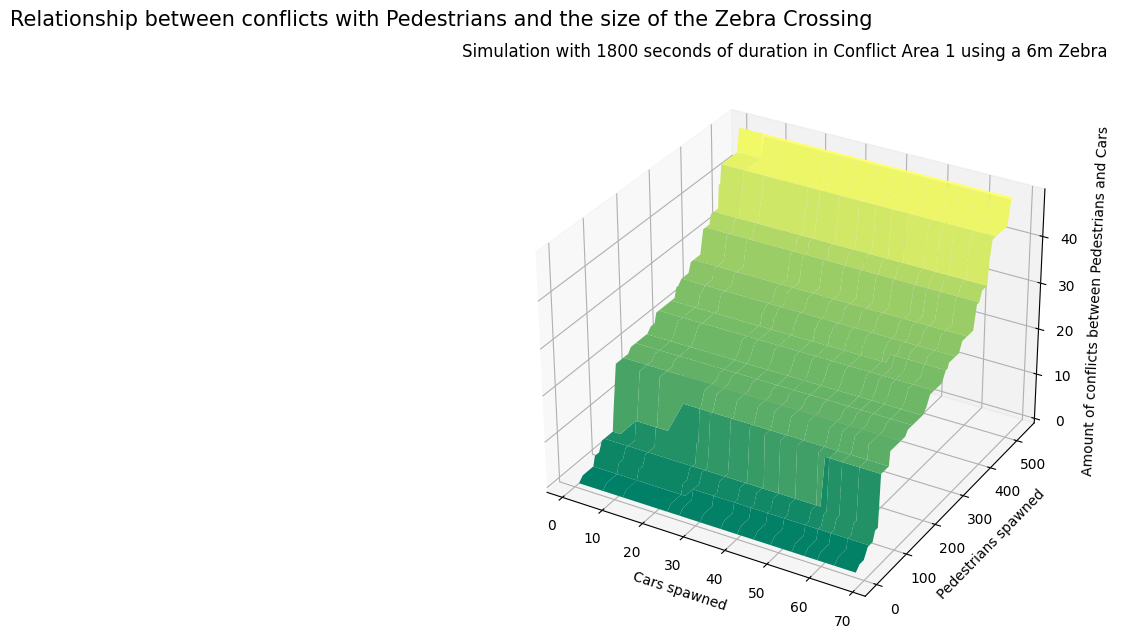

In [115]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Definition of simulation parameters

PEDESTRIAN_RATE = 0.3 # lambda parameter of the pedestrian P.Process

time_window = 1800 # Total duration of the simulation (in seconds)

# Defines how many steps fit in a second of simulation
TIME_SPLIT = 4
TRAFFIC_LIGHT_DURATION = 20
CAR_RATE = 0.08

# Defines the simulation space
SPACE_DIMENSION = 100
SIDEWALK_LENGTH = 5

crossing_road_lengths = [12]

fig = plt.figure()

data = []

for crossing_rows in crossing_road_lengths:
    results_tracker = ResultsTracker()
    process = PoissonProcess(1/TIME_SPLIT, PEDESTRIAN_RATE, CAR_RATE, sim_generator.generate_number())
    simulation = ConflictArea1(results_tracker, 1/TIME_SPLIT, TRAFFIC_LIGHT_DURATION, SPACE_DIMENSION, crossing_rows, SIDEWALK_LENGTH, process, sim_generator.generate_number())
    for _ in range(int(time_window*TIME_SPLIT)):
        simulation.simulation_step()
        if _ % 100 == 0:
            data.append((results_tracker.pedestrians_spawned, results_tracker.cars_spawned, results_tracker.conflicts_car_pedestrian))

y = []
x = []
z = []
for sample in data:
    y_sample, x_sample, z_sample = sample
    x.append(x_sample)
    y.append(y_sample)
    z.append(z_sample)


X, Y = np.meshgrid(x, y)
Z = griddata((x, y), z, (X.flatten(), Y.flatten()), 'nearest').reshape(len(x),len(y))
ax1 = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax1.plot_surface(X, Y, Z, rstride=5, cstride=5, cmap='summer',
                        linewidth=1, antialiased=True, label=f'Length of Zebra: {crossing_road_lengths[0]/2}m')
ax1.set_zlim3d(np.min(Z), np.max(Z))
ax1.set_ylabel('Pedestrians spawned')
ax1.set_xlabel('Cars spawned')
ax1.set_zlabel('Amount of conflicts between Pedestrians and Cars')

plt.suptitle("Relationship between conflicts with Pedestrians and the size of the Zebra Crossing", fontsize=15)
plt.title("Simulation with 1800 seconds of duration in Conflict Area 1 using a 6m Zebra ", fontsize=12)

plt.show()

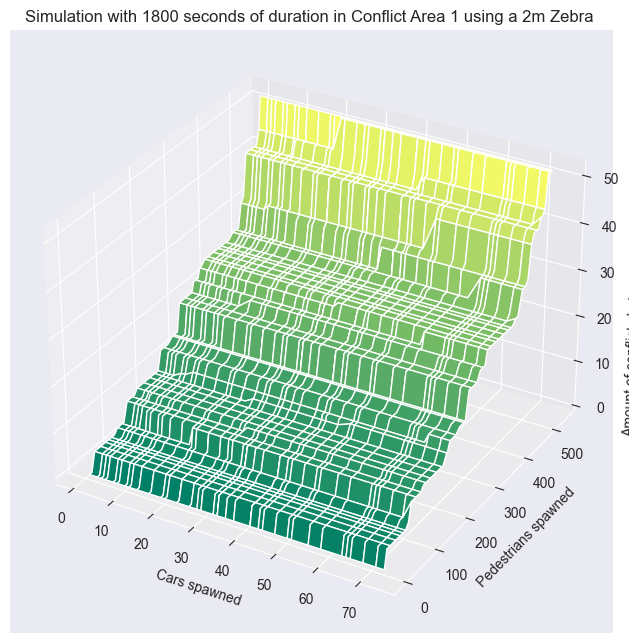

In [25]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Definition of simulation parameters

PEDESTRIAN_RATE = 0.3 # lambda parameter of the pedestrian P.Process

time_window = 1800 # Total duration of the simulation (in seconds)

# Defines how many steps fit in a second of simulation
TIME_SPLIT = 4
TRAFFIC_LIGHT_DURATION = 20
CAR_RATE = 0.08

# Defines the simulation space
SPACE_DIMENSION = 100
SIDEWALK_LENGTH = 5

crossing_road_lengths = [4]

fig = plt.figure()

data = []

for crossing_rows in crossing_road_lengths:
    results_tracker = ResultsTracker()
    process = PoissonProcess(1/TIME_SPLIT, PEDESTRIAN_RATE, CAR_RATE, sim_generator.generate_number())
    simulation = ConflictArea1(results_tracker, 1/TIME_SPLIT, TRAFFIC_LIGHT_DURATION, SPACE_DIMENSION, crossing_rows, SIDEWALK_LENGTH, process, sim_generator.generate_number())
    for _ in range(int(time_window*TIME_SPLIT)):
        simulation.simulation_step()
        if _ % 100 == 0:
            data.append((results_tracker.pedestrians_spawned, results_tracker.cars_spawned, results_tracker.conflicts_car_pedestrian))

y = []
x = []
z = []
for sample in data:
    y_sample, x_sample, z_sample = sample
    x.append(x_sample)
    y.append(y_sample)
    z.append(z_sample)


X, Y = np.meshgrid(x, y)
Z = griddata((x, y), z, (X.flatten(), Y.flatten()), 'nearest').reshape(len(x),len(y))
ax1 = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='summer', linewidth=1, antialiased=True)
ax1.set_zlim3d(np.min(Z), np.max(Z))
ax1.set_ylabel('Pedestrians spawned')
ax1.set_xlabel('Cars spawned')
ax1.set_zlabel('Amount of conflicts between Pedestrians and Cars')

plt.title("Simulation with 1800 seconds of duration in Conflict Area 1 using a 2m Zebra ", fontsize=12)

plt.show()

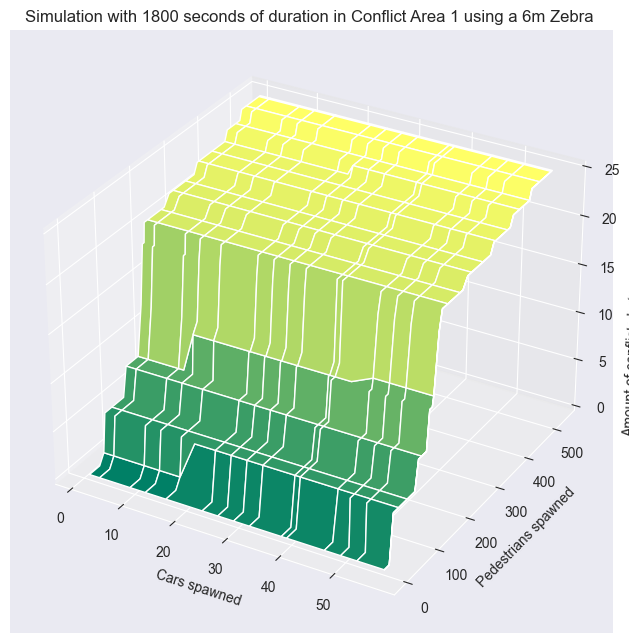

In [24]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Definition of simulation parameters

PEDESTRIAN_RATE = 0.3 # lambda parameter of the pedestrian P.Process

time_window = 1800 # Total duration of the simulation (in seconds)

# Defines how many steps fit in a second of simulation
TIME_SPLIT = 4
TRAFFIC_LIGHT_DURATION = 20
CAR_RATE = 0.08

# Defines the simulation space
SPACE_DIMENSION = 100
SIDEWALK_LENGTH = 5

crossing_road_lengths = [12]

fig = plt.figure()

data = []

for crossing_rows in crossing_road_lengths:
    results_tracker = ResultsTracker()
    process = PoissonProcess(1/TIME_SPLIT, PEDESTRIAN_RATE, CAR_RATE, sim_generator.generate_number())
    simulation = ConflictArea1(results_tracker, 1/TIME_SPLIT, TRAFFIC_LIGHT_DURATION, SPACE_DIMENSION, crossing_rows, SIDEWALK_LENGTH, process, sim_generator.generate_number())
    for _ in range(int(time_window*TIME_SPLIT)):
        simulation.simulation_step()
        if _ % 100 == 0:
            data.append((results_tracker.pedestrians_spawned, results_tracker.cars_spawned, results_tracker.conflicts_car_pedestrian))

y = []
x = []
z = []
for sample in data:
    y_sample, x_sample, z_sample = sample
    x.append(x_sample)
    y.append(y_sample)
    z.append(z_sample)


X, Y = np.meshgrid(x, y)
Z = griddata((x, y), z, (X.flatten(), Y.flatten()), 'nearest').reshape(len(x),len(y))
ax1 = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax1.plot_surface(X, Y, Z, rstride=5, cstride=5, cmap='summer',
                        linewidth=1, antialiased=True, label=f'Length of Zebra: {crossing_road_lengths[0]/2}m')
ax1.set_zlim3d(np.min(Z), np.max(Z))
ax1.set_ylabel('Pedestrians spawned')
ax1.set_xlabel('Cars spawned')
ax1.set_zlabel('Amount of conflicts between Pedestrians and Cars')

plt.title("Simulation with 1800 seconds of duration in Conflict Area 1 using a 6m Zebra ", fontsize=12)

plt.show()